In [1]:
import pandas as pd
from datetime import datetime

In [2]:
# Load the datasets
pedes_count_df = pd.read_csv('Pedestrian_Counting_System_Monthly_counts_per_hour_may_2009_to_14_dec_2022.csv')
sensor_locations_df = pd.read_csv('pedestrian-counting-system-sensor-locations.csv')

In [3]:
# Glance of the datasets
pedes_count_df.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,"November 01, 2019 05:00:00 PM",2019,November,1,Friday,17,36,Queen St (West),774


In [324]:
pedes_count_df.describe()

,ID,Year,Mdate,Time,Sensor_ID,Hourly_Counts
count,4.562230e+06,4.562230e+06,4.562230e+06,4.562230e+06,4.562230e+06,4.562230e+06
mean,2.281708e+06,2.017333e+03,1.574675e+01,1.146982e+01,2.735892e+01,4.926315e+02
std,1.317918e+06,3.580411e+00,8.799595e+00,6.938244e+00,1.978492e+01,7.475427e+02
min,1.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.140558e+06,2.015000e+03,8.000000e+00,5.000000e+00,1.100000e+01,4.300000e+01
50%,2.281116e+06,2.018000e+03,1.600000e+01,1.100000e+01,2.400000e+01,1.770000e+02
75%,3.421673e+06,2.020000e+03,2.300000e+01,1.700000e+01,4.200000e+01,6.010000e+02
max,4.567701e+06,2.022000e+03,3.100000e+01,2.300000e+01,8.700000e+01,1.597900e+04


In [21]:
# Check if Sensor_ID and Sensor_Name is one to one match. 
len(pedes_count_df['Sensor_ID'].unique()) == len(pedes_count_df['Sensor_Name'].unique())


False

In [327]:
print(len(pedes_count_df['Sensor_ID'].unique()))
print(len(pedes_count_df['Sensor_Name'].unique()))

82
94


In [328]:
# The same Sensor ID can have more than 1 name.
a = pedes_count_df[['Sensor_ID', 'Sensor_Name']].drop_duplicates()
a['Sensor_ID'].value_counts()

64    2
68    2
60    2
77    2
76    2
     ..
17    1
4     1
62    1
61    1
87    1
Name: Sensor_ID, Length: 82, dtype: int64

In [338]:
# The names for same Sensor ID.
a.loc[a['Sensor_ID']==77]

,Sensor_ID,Sensor_Name
3675240,77,Harbour Esplanade (West) - Pedestrian Pa
3711660,77,Harbour Esplanade (West) - Ped Path


In [339]:
dup_idx = a['Sensor_ID'].value_counts()[a['Sensor_ID'].value_counts()>1].index
dup_idx

Int64Index([64, 68, 60, 77, 76, 75, 72, 46, 66, 54, 67, 69], dtype='int64')

In [345]:
dup_dict = {}
for sid in dup_idx:
    dup_dict[sid] = a.loc[a['Sensor_ID']==sid]["Sensor_Name"].iloc[0]

pedes_count_df['Sensor_Name'] = pedes_count_df.apply(lambda x: dup_dict[x['Sensor_ID']] if x['Sensor_ID'] in dup_idx else x['Sensor_Name'], axis=1)

In [347]:
# Check if Sensor_ID and Sensor_Name is one to one match. 
len(pedes_count_df['Sensor_ID'].unique()) == len(pedes_count_df['Sensor_Name'].unique())

True

In [5]:
# Check if there is Null values in each column
pedes_count_df.isna().sum()

ID               0
Date_Time        0
Year             0
Month            0
Mdate            0
Day              0
Time             0
Sensor_ID        0
Sensor_Name      0
Hourly_Counts    0
dtype: int64

In [10]:
# Check the year range of the datasets
pedes_count_df["Year"].value_counts().index.sort_values()

Int64Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
            2020, 2021, 2022],
           dtype='int64')

In [348]:
# Check the year range of the datasets
print(pedes_count_df['Date_Time'].min(), pedes_count_df['Date_Time'].max())

2009-05-01 00:00:00 2022-10-31 23:00:00


## Top 10 (most pedestrians) locations by day and month

In [349]:
pedes_count_df['Date_Time'] = pd.to_datetime(pedes_count_df['Date_Time']) 

In [350]:
def agg_peds_count(df, frequency='day'):
    '''
    Sum over the pedestrains counts by different frequencies, i.e, 'day', 'month' or 'year'.
    df: the original data with 'Hourly_Counts'.
    frequency: the time frequency to sum over the counts, i.e., 'day', 'month' or 'year', default 'day'.
    '''
    if frequency == "day":
        count_df = df.groupby([pd.Grouper(key='Date_Time', freq='D'), 'Sensor_ID', 'Sensor_Name'])['Hourly_Counts']\
                    .agg(Daily_Count=sum)\
                    .sort_values('Daily_Count', ascending=False)\
                    .sort_index(level='Date_Time', sort_remaining=False)
    elif frequency == "month":
        count_df = df.groupby([pd.Grouper(key='Date_Time', freq='M'), 'Sensor_ID', 'Sensor_Name'])['Hourly_Counts']\
                    .agg(Monthly_Count=sum)\
                    .sort_values('Monthly_Count', ascending=False)\
                    .sort_index(level='Date_Time', sort_remaining=False)
    elif frequency == "year":
        count_df = df.groupby([pd.Grouper(key='Date_Time', freq='Y'), 'Sensor_ID', 'Sensor_Name'])['Hourly_Counts']\
                    .agg(Year_Count=sum)\
                    .sort_values('Year_Count', ascending=False)\
                    .sort_index(level='Date_Time', sort_remaining=False)
    else:
        print("Sorry, this is not available yet.")
        return
    return count_df

In [351]:
# Sum over daily pedestrains count in descending order based on time and locations.
peds_count_daily = agg_peds_count(pedes_count_df)
peds_count_daily

Daily_Count
Date_Time  Sensor_ID Sensor_Name                                   
2009-05-01 4         Town Hall (West)                         45185
           1         Bourke Street Mall (North)               36869
           6         Flinders Street Station Underpass        29015
           2         Bourke Street Mall (South)               27587
           5         Princes Bridge                           25590
...                                                             ...
2022-10-31 43        Monash Rd-Swanston St (West)               949
           11        Waterfront City                            923
           75        Spring St- Flinders St (West)              724
           71        Westwood Place                             683
           44        Tin Alley-Swanston St (West)               530

[190131 rows x 1 columns]

In [353]:
# Sum over monthly count in descending order based on time and locations.
peds_count_monthly = agg_peds_count(pedes_count_df, "month")
peds_count_monthly

Monthly_Count
Date_Time  Sensor_ID Sensor_Name                                        
2009-05-31 4         Town Hall (West)                            1095125
           1         Bourke Street Mall (North)                   842470
           6         Flinders Street Station Underpass            729966
           5         Princes Bridge                               711896
           2         Bourke Street Mall (South)                   628472
...                                                                  ...
2022-10-31 86        Queensberry St - Errol St (South)             43155
           78        Harbour Esplanade (West) - Bike Path          39926
           75        Spring St- Flinders St (West)                 35341
           44        Tin Alley-Swanston St (West)                  31102
           71        Westwood Place                                23682

[6384 rows x 1 columns]

### Display the top 10 (most pedestrians) locations by day

In [354]:
def _get_gkey(df, dtime):
    '''
    Comparing the keys in the groups.
    '''
    dtime = datetime.strptime(dtime, '%Y-%m')
    # print(dtime)
    key_ls = list(df.groups.keys())
    # print(key_ls)
    for key in key_ls:
        if (key.year == dtime.year) and (key.month == dtime.month):
            # print(key)
            return key
    return None

def display_top_n_locations_monthly(dtime, df, n):
    '''
    Display and return the top n most pedestrains locations by month.
    Input:
        dtime: the time in form of e.g., 2020-5
        df: the data with 'Monthly_Count' which is the monthly count pedestrains of locations.
        n: the top n most pedestrains locations to return. 

    return:
        top_df: the slice of the original data with top n most pedestrains locations by month included.

    '''
    df = df.reset_index().groupby('Date_Time')
    gkey = _get_gkey(df, dtime)
    if gkey == None:
        print("This time is not available in our database. Please choose another time.")
        return None
    df_group = df.get_group(gkey)
    top_df = df_group.nlargest(n, 'Monthly_Count')
    top_df.plot.bar(x='Sensor_Name', y='Monthly_Count', title=dtime)
    return top_df


def display_top_n_locations_daily(dtime, df, n):
    '''
    Display and return the top n most pedestraion locations by day.
    Input:
        dtime: the day in form of e.g., 2020-5-20.
        df: the data with 'Daily_Count' which is the daily count pedestrains of locations.
        n: the top n most pedestrains locations to return.
    Return:
        top_df: the slice of the original data with top n most pedestrains locations by day included.
    '''
    df = df.reset_index().groupby('Date_Time')
    df_group = df.get_group(dtime)
    top_df = df_group.nlargest(n, 'Daily_Count')
    top_df.plot.bar(x='Sensor_Name', y='Daily_Count', title=dtime)
    return top_df

#### Display the top 10 (most pedestrians) locations by day

,Date_Time,Sensor_ID,Sensor_Name,Daily_Count
179260,2022-05-20,41,Flinders La-Swanston St (West),36277
179261,2022-05-20,57,Bourke St Bridge,30693
179262,2022-05-20,35,Southbank,29585
179263,2022-05-20,25,Melbourne Convention Exhibition Centre,25466
179264,2022-05-20,3,Melbourne Central,24904
179265,2022-05-20,84,Elizabeth St - Flinders St (East) - New footpath,23611
179266,2022-05-20,66,State Library-New,22094
179267,2022-05-20,5,Princes Bridge,21649
179268,2022-05-20,6,Flinders Street Station Underpass,21388
179269,2022-05-20,24,Spencer St-Collins St (North),20548


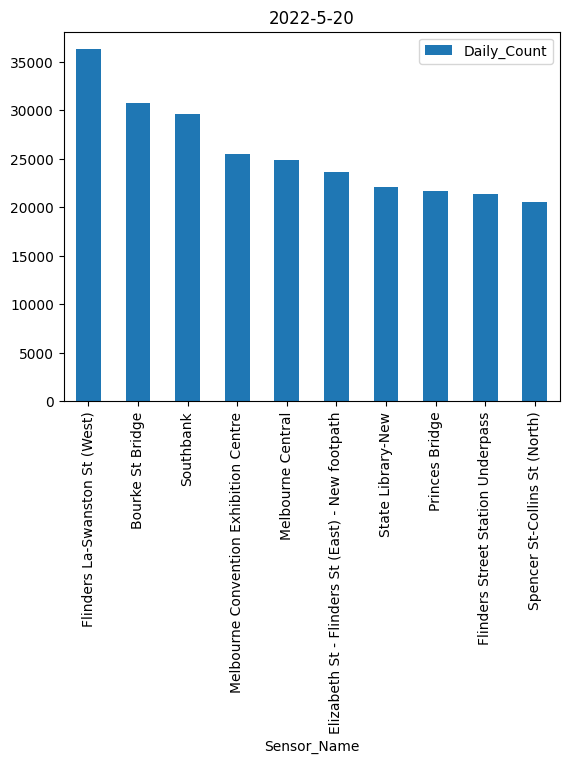

In [355]:
# Get the top 10 most pedestrains locations on 2022-5-20.
display_top_n_locations_daily('2022-5-20', peds_count_daily, 10)

#### Display the top 10 (most pedestrians) locations by month

,Date_Time,Sensor_ID,Sensor_Name,Monthly_Count
5982,2022-05-31,41,Flinders La-Swanston St (West),1002948
5983,2022-05-31,35,Southbank,828999
5984,2022-05-31,3,Melbourne Central,691828
5985,2022-05-31,84,Elizabeth St - Flinders St (East) - New footpath,649271
5986,2022-05-31,66,State Library-New,607245
5987,2022-05-31,6,Flinders Street Station Underpass,585139
5988,2022-05-31,5,Princes Bridge,583020
5989,2022-05-31,25,Melbourne Convention Exhibition Centre,574844
5990,2022-05-31,47,Melbourne Central-Elizabeth St (East),537508
5991,2022-05-31,1,Bourke Street Mall (North),531617


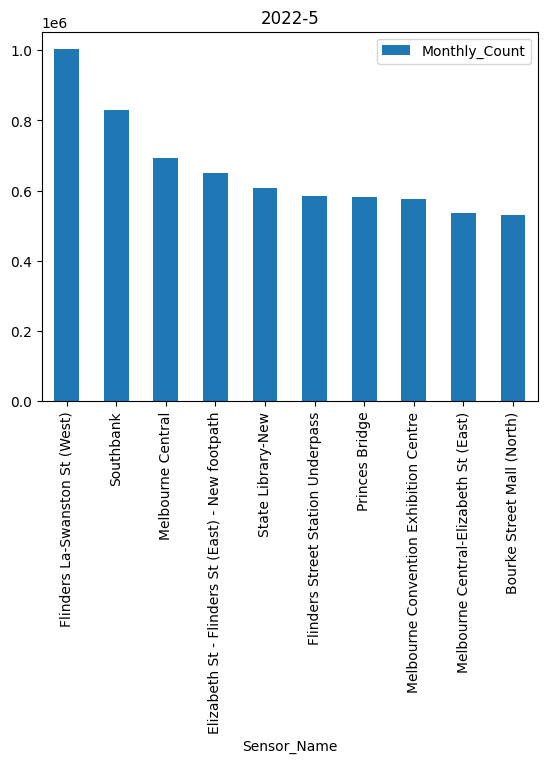

In [356]:
# Get the top 10 most pedestrains locations on 2022-5.
display_top_n_locations_monthly('2022-5', peds_count_monthly, 10)

## Which location has shown most decline due to lockdowns in last 3 years

In [357]:
# Get the last 5 years 
year_ls = pedes_count_df['Year'].unique().tolist()
year_ls.sort(reverse=True)
last_five_years = year_ls[:5]
print(last_five_years)
last_one_year = year_ls[0]
print(last_one_year)

[2022, 2021, 2020, 2019, 2018]
2022


In [358]:
# Only get the data in last 5 years
pedes_five_year_df = pedes_count_df.loc[pedes_count_df['Year'].isin(last_five_years)]
pedes_five_year_df


,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,2019-11-01 17:00:00,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,2019-11-01 17:00:00,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,2019-11-01 17:00:00,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,2019-11-01 17:00:00,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,2019-11-01 17:00:00,2019,November,1,Friday,17,36,Queen St (West),774
...,...,...,...,...,...,...,...,...,...,...
4562225,4567697,2022-10-31 19:00:00,2022,October,31,Monday,19,87,Errol St (West),185
4562226,4567698,2022-10-31 20:00:00,2022,October,31,Monday,20,87,Errol St (West),108
4562227,4567699,2022-10-31 21:00:00,2022,October,31,Monday,21,87,Errol St (West),58
4562228,4567700,2022-10-31 22:00:00,2022,October,31,Monday,22,87,Errol St (West),18


In [359]:
# Move the five years as columns
table = pd.pivot_table(pedes_five_year_df, values='Hourly_Counts', index=['Sensor_ID', 'Sensor_Name'],
                       columns=['Year'], aggfunc=sum)
table

,Year,2018,2019,2020,2021,2022
Sensor_ID,Sensor_Name,,,,,
1,Bourke Street Mall (North),11968231.0,11637901.0,4791839.0,5080187.0,5614610.0
2,Bourke Street Mall (South),8779060.0,8138004.0,3306920.0,3019402.0,3836218.0
3,Melbourne Central,10147696.0,9776584.0,4142439.0,3327672.0,6897406.0
4,Town Hall (West),12901919.0,12684222.0,5260684.0,6155040.0,3938330.0
5,Princes Bridge,11398093.0,10817578.0,4969389.0,5678430.0,6202149.0
...,...,...,...,...,...,...
79,Flinders St (South),NaN,NaN,NaN,797058.0,3198121.0
84,Elizabeth St - Flinders St (East) - New footpath,NaN,NaN,NaN,NaN,6511465.0
85,Macaulay Rd (North),NaN,NaN,NaN,NaN,571210.0


<AxesSubplot: xlabel='Sensor_ID,Sensor_Name'>

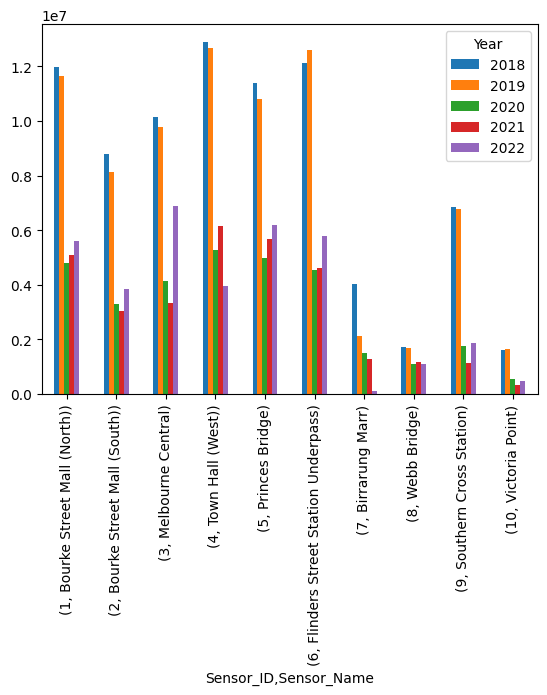

In [360]:
# Display the yearly counts for last 5 years for 10 sample locations
table.iloc[:10].plot.bar()

In [361]:
# Get the data for last 4 years
peds_four_year_pivot = table.iloc[:, 1:5]
peds_four_year_pivot

,Year,2019,2020,2021,2022
Sensor_ID,Sensor_Name,,,,
1,Bourke Street Mall (North),11637901.0,4791839.0,5080187.0,5614610.0
2,Bourke Street Mall (South),8138004.0,3306920.0,3019402.0,3836218.0
3,Melbourne Central,9776584.0,4142439.0,3327672.0,6897406.0
4,Town Hall (West),12684222.0,5260684.0,6155040.0,3938330.0
5,Princes Bridge,10817578.0,4969389.0,5678430.0,6202149.0
...,...,...,...,...,...
79,Flinders St (South),NaN,NaN,797058.0,3198121.0
84,Elizabeth St - Flinders St (East) - New footpath,NaN,NaN,NaN,6511465.0
85,Macaulay Rd (North),NaN,NaN,NaN,571210.0


In [362]:
# Remove the data with NaN values 
peds_four_year_pivot = peds_four_year_pivot.dropna()
peds_four_year_pivot

,Year,2019,2020,2021,2022
Sensor_ID,Sensor_Name,,,,
1,Bourke Street Mall (North),11637901.0,4791839.0,5080187.0,5614610.0
2,Bourke Street Mall (South),8138004.0,3306920.0,3019402.0,3836218.0
3,Melbourne Central,9776584.0,4142439.0,3327672.0,6897406.0
4,Town Hall (West),12684222.0,5260684.0,6155040.0,3938330.0
5,Princes Bridge,10817578.0,4969389.0,5678430.0,6202149.0
6,Flinders Street Station Underpass,12596799.0,4540642.0,4614701.0,5772514.0
7,Birrarung Marr,2136024.0,1502283.0,1272681.0,116120.0
8,Webb Bridge,1685096.0,1107272.0,1149161.0,1112015.0
9,Southern Cross Station,6770313.0,1765984.0,1142488.0,1859617.0


/var/folders/4t/v8sbkmsx3n77_xnnz2c0qy580000gp/T/ipykernel_47197/146840152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peds_four_year_pivot['dec_3'] = peds_four_year_pivot.apply(lambda x: int(x[2019] - (x[2020]+x[2021]+x[2022])//3), axis=1)


<AxesSubplot: xlabel='Sensor_ID,Sensor_Name'>

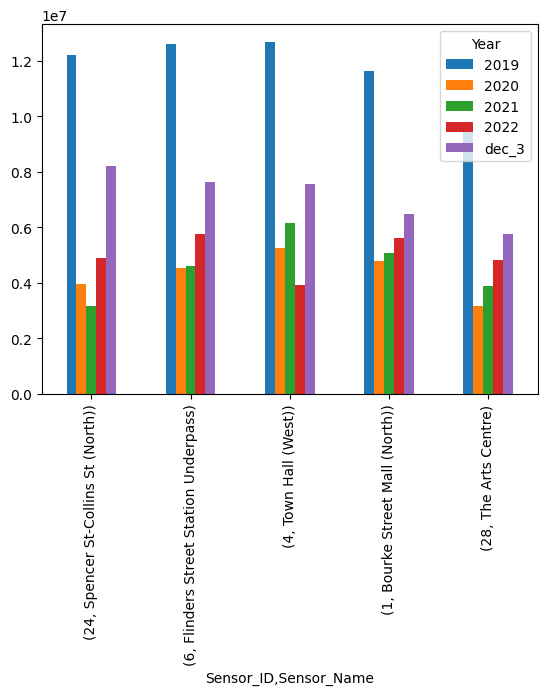

In [363]:
# Calculate the decline for the last 3 years as column 'dec_3', calculated as count[2019] - average(count[2020-2022])
peds_four_year_pivot['dec_3'] = peds_four_year_pivot.apply(lambda x: int(x[2019] - (x[2020]+x[2021]+x[2022])//3), axis=1)

# Show the top 5 most declined locations for the last 3 years
# The most declined is Spencer-St - Collins St (North)
peds_four_year_pivot.sort_values('dec_3', ascending=False).iloc[:5].plot.bar()


<AxesSubplot: ylabel='Sensor_ID,Sensor_Name'>

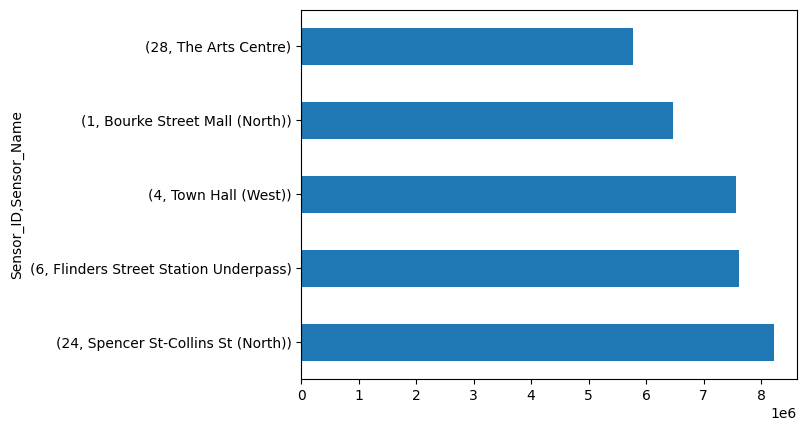

In [364]:
peds_four_year_pivot.sort_values('dec_3', ascending=False)['dec_3'].iloc[:5].plot.barh()

## Which location has most growth in last year

/var/folders/4t/v8sbkmsx3n77_xnnz2c0qy580000gp/T/ipykernel_47197/2571561732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peds_four_year_pivot['inc_1'] = peds_four_year_pivot.apply(lambda x: x[2022]-x[2021], axis=1)


<AxesSubplot: xlabel='Sensor_ID,Sensor_Name'>

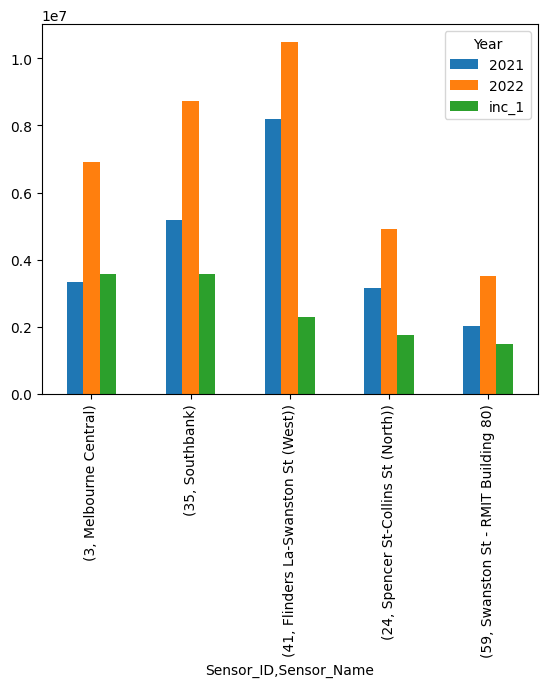

In [365]:
# Calculate the growth for the last year as column 'inc_1', calculated as count[2022] - count[2021]
peds_four_year_pivot['inc_1'] = peds_four_year_pivot.apply(lambda x: x[2022]-x[2021], axis=1)

# Show the top 5 most growth locations for the last year
# The most growth location is Melbourne Central
peds_four_year_pivot.sort_values('inc_1', ascending=False).iloc[:5, [2,3,5]].plot.bar()

<AxesSubplot: ylabel='Sensor_ID,Sensor_Name'>

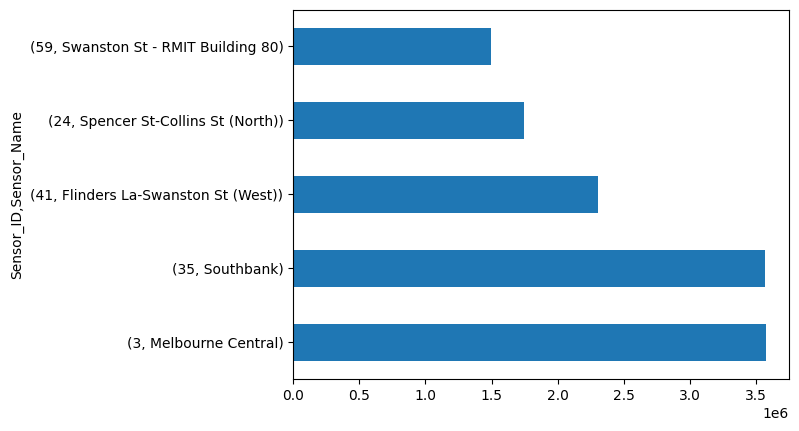

In [366]:
peds_four_year_pivot.sort_values('inc_1', ascending=False).iloc[:5]['inc_1'].plot.barh()